In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from helpers.eda import *
from helpers.data_prep import *

In [3]:
import pickle
from warnings import filterwarnings
filterwarnings("ignore")

In [4]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV,cross_validate,train_test_split,validation_curve
from sklearn.metrics import mean_absolute_error,mean_squared_error

from sklearn.decomposition import PCA

In [5]:
######################################
# Modeling
######################################

In [6]:
df = pickle.load(open("House_Price.pkl","rb"))
for col in df.columns:
    df[col] = df[col].astype(float)
    
cat_cols,num_cols,cat_but_car = grab_col_names(df,details=True)

Observations : 2919
Variables : 173
Cat Cols : 135
Num Cols : 38
Cat But Car : 0
Num But Cat : 135


In [7]:
df.head()

,Id,MSSubClass,LotFrontage,LotArea,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,...,SaleType_2,SaleType_3,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,HasGarage_1,HasFirePlace_1,Has2ndFloor_1,HasBsmt_1
0,1.0,6.0,65.0,8450.0,4.0,4.0,4.0,2.0,5.0,5.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
1,2.0,3.0,80.0,9600.0,6.0,2.0,4.0,1.0,4.0,8.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2,3.0,6.0,68.0,11250.0,4.0,4.0,4.0,2.0,5.0,5.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,4.0,7.0,60.0,9550.0,5.0,4.0,4.0,2.0,5.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4,5.0,6.0,84.0,14260.0,7.0,4.0,4.0,2.0,6.0,5.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0


In [8]:
scaler_num_cols = ['MSSubClass',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'PoolQC',
 'MiscVal',
 'MoSold',
 'GarageCarSize',
 'HomeRepairYear',
 'TotalSF',
 'SqFtPerRoom',
 'TotalPorchSF',
 'ConditionScore',
 'TotalBsmScore',
 'TotalQual',
 'QualGr']

In [9]:
scaler_num_cols == [col for col in num_cols if col not in ["Id","SalePrice"]]

True

In [10]:
print("DataFrame Shape : {}".format(df.shape))

DataFrame Shape : (2919, 173)


In [11]:
train_df = df[df["SalePrice"].notnull()]
test_df = df[df["SalePrice"].isnull()].drop("SalePrice", axis = 1)

In [12]:
X = train_df.drop(["Id","SalePrice"], axis = 1)
y = np.log1p(train_df["SalePrice"])

In [13]:
ridge_params = {"solver" : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                "alpha" : [1e-15,1e-8,1e-3,1,5,10,30,50,100] , 
                "max_iter" : [500,700,900,]}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [ 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [8, 15, 20],
             "n_estimators": [ 500, 1000]}

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.5, 0.7]}

#gbm_params = {"learning_rate": [ 0.1, 0.2 ,0.3 ,0.4],
#              "n_estimators": [ 300, 400, 500],
#              "max_depth": [ 5, 8, 12],
#              "subsample":[0.6 ,0.7 ,0.8 ,0.9]}


lightgbm_params = {"boosting_type":['gbdt','dart','goss'],
                   "learning_rate": [0.05, 0.07, 0.1, 0.2],
                   "n_estimators": [ 300, 400, 500],
                   "max_depth": [3, 5, 8],
                   "colsample_bytree": [ 0.5, 0.7, 0.8, 1]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 0.8, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500, 1500],
                   "colsample_bytree": [0.5, 0.7, 1]}

knn_params = {"n_neighbors": range(2, 50)}

regressors = [   
                
                #("Ridge" , Ridge(),ridge_params),
                #("Lasso" , Lasso()),
                #("ElasticNet", ElasticNet()),
                #("KNN", KNeighborsRegressor(),knn_params),
                ("CART" , DecisionTreeRegressor(),cart_params),
                #("RF",RandomForestRegressor(),rf_params),
                #("SVR", SVR()),
                ("GBM" , GradientBoostingRegressor(),gbm_params),
                ("XGBoost" , XGBRegressor(objective = "reg:squarederror"),xgboost_params),
                ("LightGBM" , LGBMRegressor(),lightgbm_params)
            
            ]

In [14]:
#########################
# Base Model
#########################

In [34]:
def base_model_regressors(regressors, X , y, cv =5):
    
    data = pd.DataFrame()
    index = 0
    
    for name,regressor,params in regressors:
        
        cv_results = cross_validate(estimator=regressor,
                                    X = X,
                                    y = y,
                                    cv = cv,
                                    scoring = "neg_mean_squared_error")
        
        rmse = np.sqrt(-cv_results["test_score"].mean())
        fit_time = cv_results["fit_time"].mean()
        score_time = cv_results["score_time"].mean()
    
        data.loc[index, "NAME"] = name
        data.loc[index, "RMSE"] = rmse
        data.loc[index, "FIT__TIME"] = fit_time
        data.loc[index, "SCORE_TIME"] = score_time
        index+=1
    
    data = data.sort_values(by = "RMSE")
    data = data.set_index("NAME")
    data = data.T
    
    return data

In [16]:
base_model_regressors(regressors,X,y,cv = 5)

NAME,GBM,LightGBM,XGBoost,CART
RMSE,0.125502,0.129843,0.141866,0.195177
FIT__TIME,0.577290,0.141897,0.288649,0.029366
SCORE_TIME,0.002171,0.003008,0.003787,0.001721


In [17]:
#########################
# HyperParameter Optimization Model
#########################

In [35]:
def hyperparameter_optimization_model(regressors,X,y,cv=5):
    
    index = 0
    data = pd.DataFrame()
    models_dict = {}
    
    
    for name, regressor, params in regressors:
        
        cv_results = cross_validate(estimator=regressor,
                                    X = X,
                                    y = y, 
                                    cv = cv,
                                    n_jobs=-1,
                                    verbose=0,
                                    scoring = "neg_mean_squared_error")
        
        rmse = np.sqrt(-cv_results["test_score"].mean())
        
        print("".center(50,"#"),end = "\n\n")
        
        print(f"For {type(regressor).__name__.upper()} Model", end = "\n\n")
        
        print(f"Before Grid Search :\n\nRMSE : {rmse}", end = "\n\n")
              
        best_grid = GridSearchCV(estimator=regressor,
                                 param_grid=params,
                                 cv = cv,
                                 n_jobs=-1,
                                 scoring="neg_mean_squared_error",
                                 verbose=0).fit(X,y)
              
        print(f"Best Grid : {best_grid.best_params_}",end = "\n\n")
        
        final_model = regressor.set_params(**best_grid.best_params_)
        
        models_dict[name] = final_model
        
        final_cv_results = cross_validate(estimator = final_model,
                                          X = X,
                                          y = y, 
                                          cv = cv,
                                          scoring = "neg_mean_squared_error",
                                          n_jobs = -1,
                                          verbose = 0)
        
        final_rmse = np.sqrt(-final_cv_results["test_score"].mean())
        
        print(f"After Grid Search:\n\nRMSE : {final_rmse}",end = "\n\n")
        
        data.loc[index, "NAME"] = name.upper()
        data.loc[index, "BEFORE_RMSE"] = rmse
        data.loc[index, "AFTER_RMSE"] = final_rmse
        index+=1
        
        
    data = data.sort_values(by = "AFTER_RMSE")
    data = data.set_index("NAME")
    data = data.T
    
    return data,models_dict

In [19]:
regressors = [   
                
                ("Ridge" , Ridge(),ridge_params),
                #("Lasso" , Lasso()),
                #("ElasticNet", ElasticNet()),
                ("KNN", KNeighborsRegressor(),knn_params),
                ("CART" , DecisionTreeRegressor(),cart_params),
                #("RF",RandomForestRegressor(),rf_params),
                #("SVR", SVR()),
                #("GBM" , GradientBoostingRegressor(),gbm_params),
                ("XGBoost" , XGBRegressor(objective = "reg:squarederror"),xgboost_params),
                ("LightGBM" , LGBMRegressor(),lightgbm_params)
            
            ]

In [20]:
data , models_dict = hyperparameter_optimization_model(regressors, X , y, cv = 5)

##################################################

For RIDGE Model

Before Grid Search :

RMSE : 0.12906327871143142

Best Grid : {'alpha': 50, 'max_iter': 500, 'solver': 'svd'}

After Grid Search:

RMSE : 0.1256736862632803

##################################################

For KNEIGHBORSREGRESSOR Model

Before Grid Search :

RMSE : 0.20598921431727402

Best Grid : {'n_neighbors': 8}

After Grid Search:

RMSE : 0.20263459624797986

##################################################

For DECISIONTREEREGRESSOR Model

Before Grid Search :

RMSE : 0.197813176870843

Best Grid : {'max_depth': 11, 'min_samples_split': 20}

After Grid Search:

RMSE : 0.17935706139353436

##################################################

For XGBREGRESSOR Model

Before Grid Search :

RMSE : 0.14186593145926385

Best Grid : {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

After Grid Search:

RMSE : 0.1274020869112321

##################################################



In [21]:
data

NAME,LIGHTGBM,RIDGE,XGBOOST,CART,KNN
BEFORE_RMSE,0.129843,0.129063,0.141866,0.197813,0.205989
AFTER_RMSE,0.124676,0.125674,0.127402,0.179357,0.202635


In [22]:
models_dict

{'Ridge': Ridge(alpha=50, max_iter=500, solver='svd'),
 'KNN': KNeighborsRegressor(n_neighbors=8),
 'CART': DecisionTreeRegressor(max_depth=11, min_samples_split=20),
 'XGBoost': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None),
 'LightGBM': LGBMRegressor(colsample_bytree=0.5, learning_rate=0.01, n_estimators=1500)}

In [23]:
for name,regressor,params in regressors:
    
    models_dict[name].fit(X,y)
    
    pd.to_pickle(models_dict[name], open("Final_"+name.upper()+"_Model.pkl","wb"))

In [24]:
#########################
# VotingRegressor Model
#########################

In [25]:
from sklearn.ensemble import VotingRegressor

In [36]:
def votingregressor_model(estimators,X,y,cv = 5):
    
    data = pd.DataFrame()
    index = 0
    
    voting_regressor = VotingRegressor(estimators=estimators,
                                       n_jobs=-1,
                                       verbose=False)
    
    voting_regressor = voting_regressor.fit(X,y)
    
    cv_results = cross_validate(estimator=voting_regressor,
                                X = X,
                                y = y,
                                cv = cv,
                                n_jobs=-1,
                                verbose=0,
                                scoring = "neg_mean_squared_error")
    
    data.loc[index,"NAME"] = ["VotingRegressor"]
    data.loc[index,"RMSE"] = np.sqrt(-cv_results["test_score"].mean())
    data.loc[index,"FIT_TIME"] = cv_results["fit_time"].mean()
    data.loc[index,"SCORE_TIME"] = cv_results["score_time"].mean()
    
    data = data.set_index("NAME")
    
    return data

In [27]:
estimators = [ (name,models_dict[name]) for name,regressor,params in regressors if name not in ["Ridge","KNN"]]
estimators

[('CART', DecisionTreeRegressor(max_depth=11, min_samples_split=20)),
 ('XGBoost',
  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.1, max_delta_step=0, max_depth=5,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method='exact', validate_parameters=1, verbosity=None)),
 ('LightGBM',
  LGBMRegressor(colsample_bytree=0.5, learning_rate=0.01, n_estimators=1500))]

In [28]:
voting_data = votingregressor_model(estimators,X,y, cv = 5)

In [29]:
data

NAME,LIGHTGBM,RIDGE,XGBOOST,CART,KNN
BEFORE_RMSE,0.129843,0.129063,0.141866,0.197813,0.205989
AFTER_RMSE,0.124676,0.125674,0.127402,0.179357,0.202635


In [30]:
voting_data

,RMSE,FIT_TIME,SCORE_TIME
NAME,,,
VotingRegressor,0.131068,3.607057,0.028344


In [31]:
################################################
# Feature Importance
################################################

In [37]:
def feature_importance(models,X,num=10,save = False):
    
    data = pd.DataFrame({"RATIO" : models.feature_importances_,
                         "FEATURES" : X.columns}).sort_values(by = "RATIO", ascending = False)[0:num]
    
    plt.figure(figsize = (10,7))
    sns.barplot(y = data["FEATURES"], x = data["RATIO"])
    plt.title("FEAURES")
    plt.show()
    
    if save:
        plt.savefig(type(models).__name__+"importance.png")

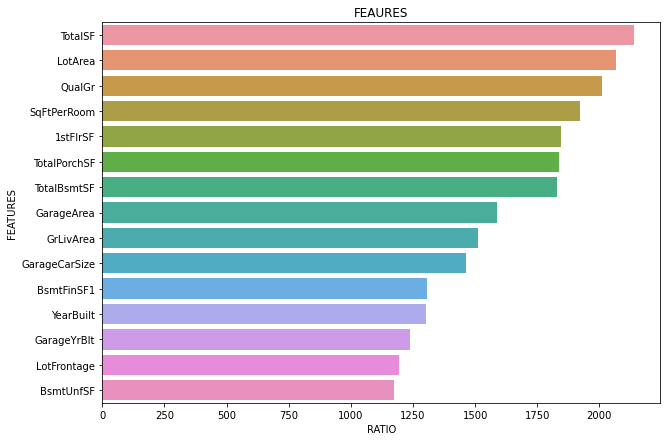

<Figure size 432x288 with 0 Axes>

In [33]:
feature_importance(models_dict["LightGBM"],X,num = 15, save = True)

In [34]:
################################################
# Analyzing Model Complexity with Learning Curves (BONUS)
################################################

In [35]:
models_dict


{'Ridge': Ridge(alpha=50, max_iter=500, solver='svd'),
 'KNN': KNeighborsRegressor(n_neighbors=8),
 'CART': DecisionTreeRegressor(max_depth=11, min_samples_split=20),
 'XGBoost': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
 'LightGBM': LGBMRegressor(colsample_bytree=0.5, learning_rate=0.01, n_estimators=1500)}

In [36]:
new_lightgbm_params = {"learning_rate" : [0.01, 0.1, 0.2, 0.3],
                       "n_estimators" : [300,500,1500],
                       "colsample_bytree": [0.5, 0.7, 1]}
new_lightgbm_params

{'learning_rate': [0.01, 0.1, 0.2, 0.3],
 'n_estimators': [300, 500, 1500],
 'colsample_bytree': [0.5, 0.7, 1]}

In [38]:
def val_curve_params(estimator, X ,y , param_name, param_range, scoring, cv = 5 ):
    
    train_scores ,test_scores = validation_curve(estimator = estimator, 
                                                 X = X,
                                                 y = y,
                                                 cv = cv,
                                                 param_name = param_name,
                                                 param_range = param_range,
                                                 n_jobs = -1,
                                                 verbose = 0,
                                                 scoring = scoring)
    
    mean_train_scores = np.mean(train_scores, axis = 1)
    mean_test_scores = np.mean(test_scores, axis = 1)
    
    plt.plot(param_range, mean_train_scores, label = " TRANING SCORES ", color = "g")
    plt.plot(param_range, mean_test_scores, label = " VALIDATION SCORES ", color = "r")
    
    plt.title(f"Validation Curve For {type(estimator).__name__.upper()}")
    plt.xlabel(f"Number Of {param_range} : {param_name}")
    plt.ylabel(f"{scoring}")
    plt.legend(loc = "best")
    plt.show()

In [38]:
for i in new_lightgbm_params:
    print(i,":",models_dict["LightGBM"].get_params()[i])

learning_rate : 0.01
n_estimators : 1500
colsample_bytree : 0.5


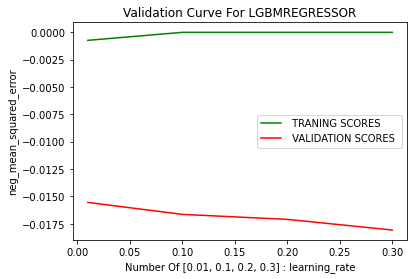

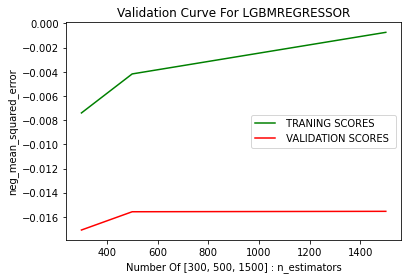

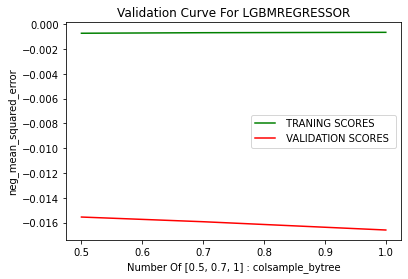

In [39]:
for i in new_lightgbm_params:
    
    val_curve_params(estimator = models_dict["LightGBM"], 
                     X = X, 
                     y = y, 
                     param_name = i,
                     param_range = new_lightgbm_params[i],
                     scoring="neg_mean_squared_error")

In [40]:
######################################################
# Prediction for a New Observation
######################################################

In [41]:
random_select = X.sample(1, random_state = 14)
random_target = y.loc[random_select.index].values
random_target

array([11.75587949])

In [42]:
models_dict["LightGBM"].predict(random_select)

array([11.78288825])

In [43]:
######################################
# Actual Values vs Estimated Value
######################################

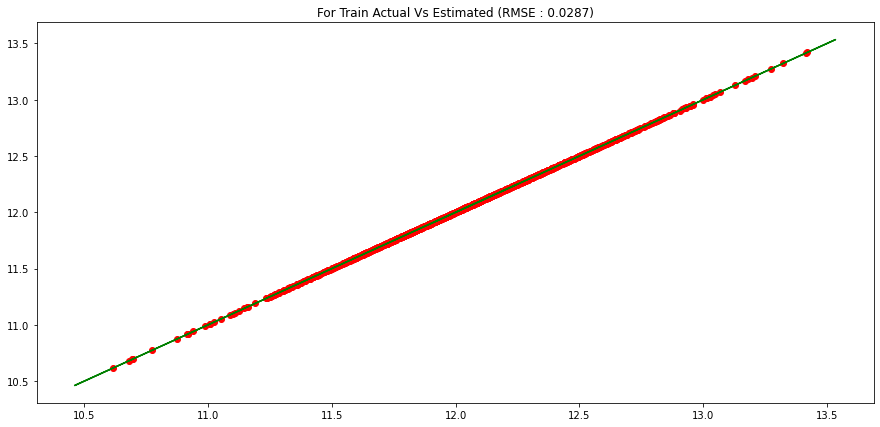

In [44]:
y_pred = models_dict["LightGBM"].predict(X)
rmse = np.sqrt(mean_squared_error(y,y_pred))
rmse = round(rmse,4)


plt.figure(figsize = (15,7))
plt.plot(y,y, color = "g")
plt.scatter(y_pred,y_pred, color = "r")
plt.title(f"For Train Actual Vs Estimated (RMSE : {rmse})")
plt.show()

In [45]:
######################################
#Loading Results
######################################

In [46]:
submission_df = pd.DataFrame()
submission_df["Id"] = test_df["Id"].astype(int)

In [47]:
y_pred_sub = models_dict["LightGBM"].predict(test_df.drop("Id",axis = 1))
y_pred_sub = np.expm1(y_pred_sub)

submission_df["SalePrice"] = y_pred_sub
submission_df.to_csv("submission.csv",index = False)


In [48]:
submission_df

,Id,SalePrice
1460,1461,111127.262344
1461,1462,163107.299884
1462,1463,188965.312132
1463,1464,192344.851946
1464,1465,180198.189687
...,...,...
2914,2915,84263.960583
2915,2916,80694.202352
2916,2917,163815.522895
2917,2918,116671.994961


In [49]:
################################
# Principal Component Analysis
################################

In [14]:
cat_cols, num_cols, cat_but_car =grab_col_names(df,details=True)

Observations : 2919
Variables : 173
Cat Cols : 135
Num Cols : 38
Cat But Car : 0
Num But Cat : 135


In [15]:
scaler_num_cols == [col for col in num_cols if col not in ["Id","SalePrice"]]

True

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[scaler_num_cols] = scaler.fit_transform(df[scaler_num_cols])

pca = PCA()
pca_fit = pca.fit_transform(df[scaler_num_cols])
pca_fit

array([[ 1.47727867e+00, -1.16803529e+00, -1.54626504e+00, ...,
        -3.78299755e-03, -1.09505337e-02,  1.65064087e-16],
       [-8.35608002e-02, -3.55397377e-01,  2.05881541e+00, ...,
         9.35399849e-03, -1.27354583e-02,  1.42409098e-16],
       [ 1.94705142e+00, -6.44176416e-01, -1.83599336e+00, ...,
        -5.06893294e-03, -2.93040663e-03,  2.78429540e-17],
       ...,
       [ 1.00728637e+00,  1.35700705e+00,  1.58472422e+00, ...,
         2.16672037e-02, -5.39817578e-02,  5.21807977e-17],
       [-2.97634688e+00, -5.51003203e-01, -7.97120712e-01, ...,
        -1.77604197e-02,  2.28371838e-02, -2.85262342e-17],
       [ 1.68009743e+00,  5.52551312e-01,  2.26959281e-01, ...,
         1.20386022e-02, -3.91783862e-02, -2.07025597e-17]])

In [17]:
np.cumsum(pca.explained_variance_ratio_)

array([0.22863172, 0.31369523, 0.38465002, 0.43865319, 0.48931986,
       0.53485823, 0.57641781, 0.61358857, 0.64598613, 0.67636382,
       0.70533622, 0.73343827, 0.76107625, 0.78763241, 0.81402568,
       0.8400135 , 0.86467967, 0.88798534, 0.90869468, 0.92769201,
       0.94425349, 0.9574263 , 0.96710952, 0.97626807, 0.9838274 ,
       0.98848787, 0.9928456 , 0.99598414, 0.99791493, 0.99886858,
       0.99922164, 0.99955085, 0.99975223, 0.99988276, 1.        ,
       1.        ])

In [18]:
################################
# Optimum Number of Components
################################

In [21]:
number_size = len(np.cumsum(pca.explained_variance_ratio_))

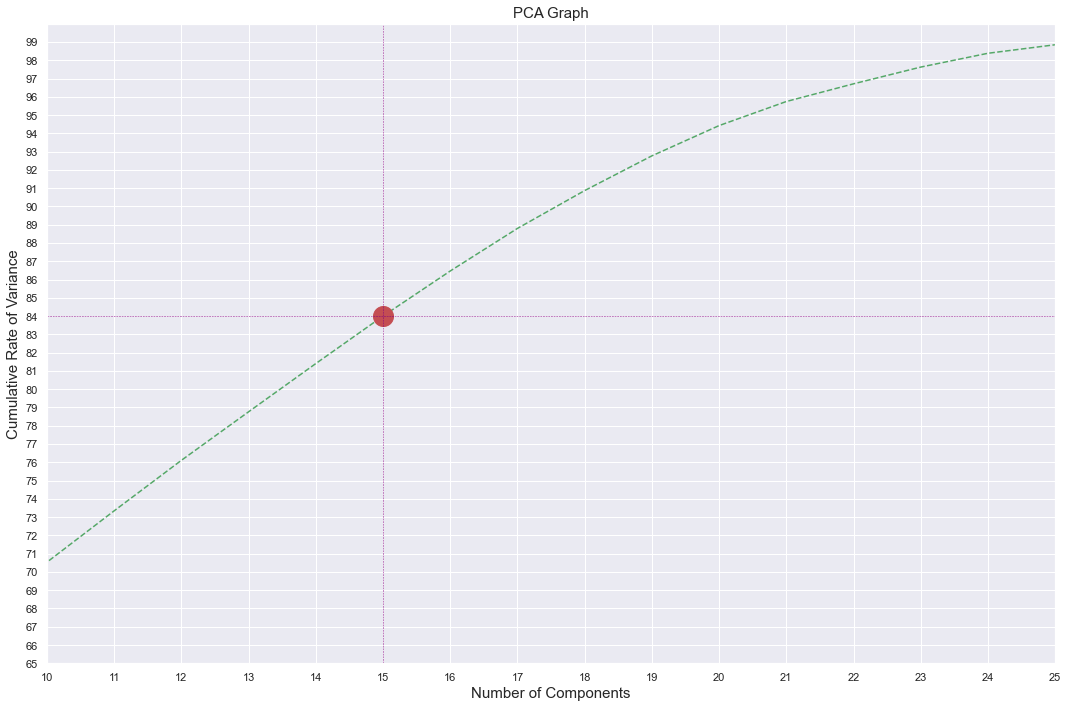

In [22]:
plt.figure(figsize = (15,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_)* 100,"--",color = "g")
plt.plot(15,84,"o",color = "r", markersize = 20)

plt.axhline(84,linestyle = "--",color ="purple",linewidth = .5)
plt.axvline(15,linestyle = "--",color ="purple",linewidth = .5)

plt.xticks(range(0,number_size))
plt.yticks(range(22,100))

size = 15
plt.title("PCA Graph",fontsize = size)
plt.xlabel("Number of Components" , fontsize = size)
plt.ylabel("Cumulative Rate of Variance" , fontsize = size)

plt.xlim([10,25])
plt.ylim([65,100])
sns.set()

plt.tight_layout()
plt.show()

In [23]:
################################
# Creation of Final PCA
################################

In [24]:
final_pca = PCA(n_components=15)
final_pca_fit = final_pca.fit_transform(df[scaler_num_cols])

np.cumsum(final_pca.explained_variance_ratio_)

array([0.22863172, 0.31369523, 0.38465002, 0.43865319, 0.48931986,
       0.53485823, 0.57641781, 0.61358857, 0.64598613, 0.67636382,
       0.70533622, 0.73343827, 0.76107625, 0.78763241, 0.81402567])

In [25]:
print("Final PCA Shape : {}".format(final_pca_fit.shape))

Final PCA Shape : (2919, 15)


In [26]:
pca_columns = ["PCA_"+str(i) for i in range(1,16)]

pca_data = pd.DataFrame(data = final_pca_fit, columns = pca_columns)
pca_data

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15
0,1.477279,-1.168035,-1.546265,0.159094,1.598277,-0.644008,-1.588470,0.791407,0.642751,0.143916,0.675788,-0.011076,0.583474,-0.229505,-0.083585
1,-0.083561,-0.355398,2.058814,0.181261,0.293543,-0.888009,0.463777,0.166117,-1.177152,1.212508,-1.034010,0.226907,0.420854,-0.505900,1.552790
2,1.947051,-0.644177,-1.835994,-0.054055,0.833093,-0.083145,-1.729242,0.130554,1.179874,0.340880,-0.385239,0.272051,-1.140393,0.396836,-0.233934
3,-0.465305,2.863549,-2.605261,-0.187641,-0.524534,-0.778500,1.078020,-0.560175,1.906356,0.638038,0.461833,-0.187975,0.537040,-1.974334,-1.457267
4,4.455521,0.575687,-1.358721,-0.292908,0.890430,-0.603799,-1.274181,-0.138980,-0.506819,0.168494,0.456235,-0.202066,0.851616,-0.732228,0.180911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,-5.196648,-1.318020,-0.140014,-0.313919,2.108964,2.029130,1.543659,2.114772,-0.820244,-0.687414,-0.559860,0.027148,-0.276942,0.354566,-0.337148
2915,-3.797843,-1.988721,0.706243,-0.035381,2.572816,1.343263,0.250930,-0.269721,1.027396,-0.341311,0.210800,-0.048901,0.412971,0.085990,-0.161386
2916,1.007286,1.357007,1.584724,0.320581,-1.105773,-3.764040,0.512125,-0.996019,-1.320945,1.715440,-0.917463,0.362178,-1.879635,-0.247163,0.612519
2917,-2.976347,-0.550997,-0.797106,0.271220,-0.133714,-0.222901,0.337439,1.994573,-3.140108,0.556309,-0.526862,1.050346,-0.932666,0.669052,-0.026822


In [27]:
print("DataFrame Shape : {}".format(df.shape))

DataFrame Shape : (2919, 173)


In [28]:
drop_df = df.drop(scaler_num_cols, axis = 1)
pca_df = pd.concat([drop_df,pca_data],axis = 1)

print("PCA DataFrame Shape : {}".format(pca_df.shape))

PCA DataFrame Shape : (2919, 152)


In [29]:
pca_df.head()

,Id,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,BedroomAbvGr,TotRmsAbvGrd,FireplaceQu,...,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15
0,1.0,4.0,4.0,4.0,2.0,5.0,5.0,3.0,6.0,2.0,...,-0.644008,-1.588470,0.791407,0.642751,0.143916,0.675788,-0.011076,0.583474,-0.229505,-0.083585
1,2.0,6.0,2.0,4.0,1.0,4.0,8.0,3.0,4.0,4.0,...,-0.888009,0.463777,0.166117,-1.177152,1.212508,-1.034010,0.226907,0.420854,-0.505900,1.552790
2,3.0,4.0,4.0,4.0,2.0,5.0,5.0,3.0,4.0,4.0,...,-0.083145,-1.729242,0.130554,1.179874,0.340880,-0.385239,0.272051,-1.140393,0.396836,-0.233934
3,4.0,5.0,4.0,4.0,2.0,5.0,5.0,3.0,5.0,5.0,...,-0.778500,1.078020,-0.560175,1.906356,0.638038,0.461833,-0.187975,0.537040,-1.974334,-1.457267
4,5.0,7.0,4.0,4.0,2.0,6.0,5.0,4.0,7.0,4.0,...,-0.603799,-1.274181,-0.138980,-0.506819,0.168494,0.456235,-0.202066,0.851616,-0.732228,0.180911


In [30]:
pca_train_df = pca_df[pca_df["SalePrice"].notnull()]
pca_test_df = pca_df[pca_df["SalePrice"].isnull()].drop("SalePrice",axis = 1)

In [31]:
pca_X = pca_train_df.drop(["Id","SalePrice"],axis = 1)
pca_Y = np.log1p(pca_train_df["SalePrice"])

In [32]:
################################
# Base Models
################################

In [39]:
base_model_regressors(regressors,pca_X,pca_Y,cv = 5)

NAME,GBM,LightGBM,XGBoost,CART
RMSE,0.124828,0.129180,0.132811,0.181363
FIT__TIME,0.559608,0.162192,0.320413,0.033006
SCORE_TIME,0.002133,0.002905,0.003822,0.001954


In [186]:
#########################
# HyperParameter Optimization Model
#########################

In [40]:
regressors = [   
                
                #("Ridge" , Ridge(),ridge_params),
                #("Lasso" , Lasso()),
                #("ElasticNet", ElasticNet()),
                #("KNN", KNeighborsRegressor(),knn_params),
                ("CART" , DecisionTreeRegressor(),cart_params),
                #("RF",RandomForestRegressor(),rf_params),
                #("SVR", SVR()),
                #("GBM" , GradientBoostingRegressor(),gbm_params),
                ("XGBoost" , XGBRegressor(objective = "reg:squarederror"),xgboost_params),
                ("LightGBM" , LGBMRegressor(),lightgbm_params)
            
            ]

In [41]:
PCA_data, PCA_models_dict = hyperparameter_optimization_model(regressors,pca_X,pca_Y,cv=5)

##################################################

For DECISIONTREEREGRESSOR Model

Before Grid Search :

RMSE : 0.18510249896601552

Best Grid : {'max_depth': 6, 'min_samples_split': 21}

After Grid Search:

RMSE : 0.16059269297091255

##################################################

For XGBREGRESSOR Model

Before Grid Search :

RMSE : 0.132810503250086

Best Grid : {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

After Grid Search:

RMSE : 0.12379762744694352

##################################################

For LGBMREGRESSOR Model

Before Grid Search :

RMSE : 0.12918035321476032

Best Grid : {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'n_estimators': 1500}

After Grid Search:

RMSE : 0.1260330841759891



In [43]:
PCA_data

NAME,XGBOOST,LIGHTGBM,CART
BEFORE_RMSE,0.132811,0.129180,0.185102
AFTER_RMSE,0.123798,0.126033,0.160593


In [44]:
PCA_models_dict

{'CART': DecisionTreeRegressor(max_depth=6, min_samples_split=21),
 'XGBoost': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None),
 'LightGBM': LGBMRegressor(colsample_bytree=0.5, learning_rate=0.01, n_estimators=1500)}

In [42]:
for name,regressor,params in regressors:
    
    PCA_models_dict[name].fit(pca_X,pca_Y)
    pd.to_pickle(PCA_models_dict[name], open("PCA_Final_"+name+"_Model.pkl", "wb"))

In [45]:
################################################
# Feature Importance
################################################

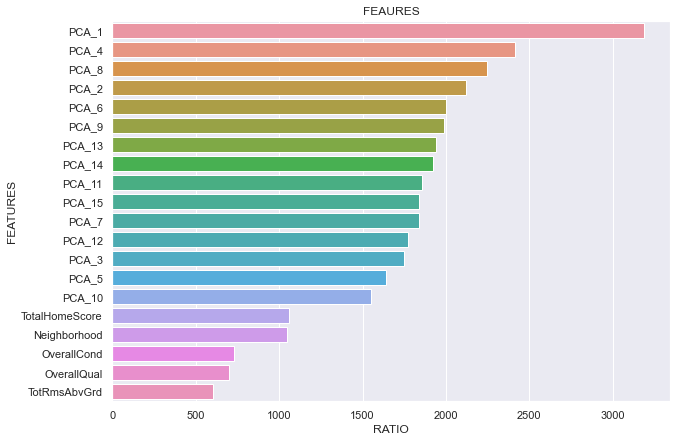

<Figure size 432x288 with 0 Axes>

In [46]:
feature_importance(PCA_models_dict["LightGBM"],pca_X,num = 20, save = True)

In [47]:
################################################
# Analyzing Model Complexity with Learning Curves (BONUS)
################################################

In [51]:
for i in lightgbm_params:
    print(i, ":", PCA_models_dict["LightGBM"].get_params()[i])

learning_rate : 0.01
n_estimators : 1500
colsample_bytree : 0.5


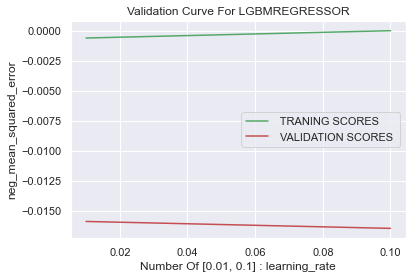

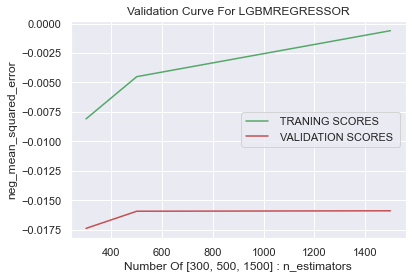

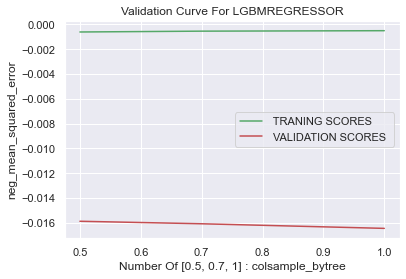

In [52]:
for i in lightgbm_params:
    val_curve_params(PCA_models_dict["LightGBM"], 
                     pca_X, 
                     pca_Y, 
                     param_name=i,
                     param_range = lightgbm_params[i],
                     scoring = "neg_mean_squared_error",
                     cv = 5)

In [53]:
######################################################
# Prediction for a New Observation
######################################################

In [57]:
random_select_pca = pca_X.sample(1,random_state = 42)
random_pca_values = pca_Y.loc[random_select_pca.index].values
random_pca_values

array([11.94795585])

In [59]:
PCA_models_dict["LightGBM"].predict(random_select_pca)

array([11.92004554])

In [60]:
######################################
# Actual Values vs Estimated Values
######################################

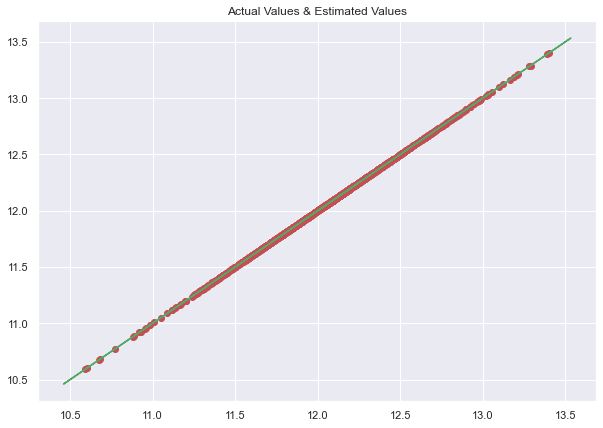

In [61]:
y_pred_pca = PCA_models_dict["LightGBM"].predict(pca_X)

plt.figure(figsize = (10,7))
plt.plot(pca_Y, pca_Y, color = "g",label = "Actual_Values")
plt.scatter(y_pred_pca,y_pred_pca, color = "r", label = "Estimated_Values")

plt.title("Actual Values & Estimated Values")

plt.show()

In [62]:
######################################
#Loading Results
######################################

In [63]:
submission_df_pca = pd.DataFrame()
submission_df_pca["Id"] = test_df["Id"].astype(int)

In [68]:
y_pred_pca_test = PCA_models_dict["LightGBM"].predict( pca_test_df.drop("Id",axis = 1) )

submission_df_pca["SalePrice"] = np.expm1(y_pred_pca_test)

submission_df_pca.to_csv("Submission_PCA.csv",index = False)

In [69]:
submission_df_pca.head()

,Id,SalePrice
1460,1461,120384.727904
1461,1462,162264.431029
1462,1463,184016.580962
1463,1464,189933.395526
1464,1465,190232.598474
